# Production d'une étude de marché

## 0. Paramétrage de l'environnement de travail

In [80]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [81]:
import pandas as pd
import numpy as np
import numpy, math
import scipy as st
import seaborn as sns
import warnings
import sklearn.metrics as sm
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.lines as mlines

from sklearn import decomposition, preprocessing, metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.stats import *
from scipy.stats import norm
from scipy.stats import ks_2samp
from scipy.stats import chi2_contingency 
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, cophenet
from scipy.spatial.distance import cdist
from pylab import rcParams
from matplotlib.collections import LineCollection

%matplotlib inline

In [82]:
# rcParams["figure.figsize"] = 20,10
# rcParams ['font.size'] = 30

sns.set()
sns.set_context('talk')
sns.set_palette('Set1')

In [83]:
# functions
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(10,10))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)
            # an = np.linspace(0, 2 * np.pi, 100)  # Add a unit circle for scale
            # plt.plot(np.cos(an), np.sin(an))
            
            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.axis('equal')
            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(15,10))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def plot_distribution(inp):
  plt.figure
  ax = sns.distplot(inp)
  plt.axvline(np.mean(inp), color="k", linestyle="dashed", linewidth=5)
  _, max_ = plt.ylim()
  plt.text(
      inp.mean() + inp.mean() / 10,
      max_ - max_ / 10,
      "Mean: {:.2f}".format(inp.mean()),
  )
  return plt.figure

# function scree plot
def display_scree_plot(pca):     
  fig, ax = plt.subplots(figsize=(10,10))
  sns.set_context('talk')
  
  scree = pca.explained_variance_ratio_*100
  plt.bar(np.arange(len(scree))+1, scree, color='blue')
  plt.plot(np.arange(len(scree))+1, scree.cumsum(), c="red", marker='o')

  plt.xlabel("rang de l'axe d'inertie")
  plt.ylabel("pourcentage d'inertie")
  plt.title("Eboulis des valeurs propres")
  plt.show(block=False)

In [84]:
population = pd.read_csv("/content/drive/MyDrive/OC/P5/P5_rawfiles/P5_population.csv")
animaux = pd.read_csv("/content/drive/MyDrive/OC/P5/P5_rawfiles/P5_animaux.csv")
vegetaux = pd.read_csv("/content/drive/MyDrive/OC/P5/P5_rawfiles/P5_vegetaux.csv")

## 1. Création du DataFrame et des variables nécessaires à l'étude

Les données utilisées ici sont issues du site de la FAO (http://www.fao.org/faostat/fr/#data). On a découpé nos données en trois fichiers csv contenant les informations sur les bilans alimentaires animaux et végétaux de 2017 et les informations sur la population de chaque pays en 2017. Le choix s'est porté sur l'année 2017 car il s'agit de l'année où l'on dispose de toutes les données nécessaires les plus récentes. Concernant la sélection des pays, pour éviter la présence d'un doublon, la Chine n'a pas été sélectionné en tant qu'agrégat. En revanche, les données de la Chine sont présentes à travers une division en quatre : la Chine continentale, Macao, Taïwan et Hong Kong.

### 1.1. Nettoyage des fichiers

Avant de débuter toute analyse, on va nettoyer nos différents fichiers. On commence d'abord par rechercher les valeurs manquantes.

In [85]:
print('Détails des valeurs manquantes pour la population:\n' + str(population.isna().sum()) + '\n')
print('Détails des valeurs manquantes pour le bilan alimentaire des produits animaux:\n' + str(animaux.isna().sum()) + '\n' )
print('Détails des valeurs manquantes pour le bilan alimentaire des produits végétaux:\n' + str(vegetaux.isna().sum()) + '\n' )

Détails des valeurs manquantes pour la population:
Code Domaine                0
Domaine                     0
Code zone (FAO)             0
Zone                        0
Code Élément                0
Élément                     0
Code Produit                0
Produit                     0
Code année                  0
Année                       0
Unité                       0
Valeur                      0
Symbole                     0
Description du Symbole      0
Note                      469
dtype: int64

Détails des valeurs manquantes pour le bilan alimentaire des produits animaux:
Code Domaine              0
Domaine                   0
Code zone                 0
Zone                      0
Code Élément              0
Élément                   0
Code Produit              0
Produit                   0
Code année                0
Année                     0
Unité                     0
Valeur                    0
Symbole                   0
Description du Symbole    0
dtype: int64



Aucune valeur manquante ne se trouve dans nos données. On regarde ensuite s'il existe des valeurs dupliquées.

In [86]:
print('Valeurs dupliquées pour la population : ' + str(population.duplicated().sum()))
print('Valeurs dupliquées pour le bilan alimentaire des produits animaux : ' + str(animaux.duplicated().sum()))
print('Valeurs dupliquées pour le bilan alimentaire des produits végétaux : ' + str(vegetaux.duplicated().sum()))

Valeurs dupliquées pour la population : 0
Valeurs dupliquées pour le bilan alimentaire des produits animaux : 0
Valeurs dupliquées pour le bilan alimentaire des produits végétaux : 0


Aucune valeur dupliquée ne se trouve dans nos données. On peut donc créer les quatre variables nécessaires à la base de notre étude de marché. 

### 1.2. Création des différentes variables nécessaires à l'étude de marché

Pour notre étude de marché, nous allons créer quatre variables pour chaque pays de notre échantillon : une variable reflétant la différence de population entre l'année courante et l'année antérieure (ici 2017 et 2016) exprimée en pourcentage, la proportion de protéines animales sur la proportion de protéines totales disponibles, la disponibilité alimentaire totale exprimée en calories par habitant et la disponibilité alimentaire totale exprimée en protéines par habitant. Ces variables vont être créer à partir des données extraites du site de la FAO.

#### 1.2.1. Création de la variable : *croissance de la population*

La variable **croissance de la population** (nommée *croissance_pop*) représente la différence de population entre l'année 2017 et l'année 2016 et est exprimée en pourcentage.

In [87]:
population = population.rename(columns={"Code zone (FAO)" : "Code zone"})
population = population[['Code zone', 'Zone', 'Année', 'Valeur']]
population["Valeur"] *= 1000
population = population.loc[(population['Année'] == 2017) | (population['Année'] == 2018)]
population['croissance_pop_(en %)'] = round(population.groupby('Zone')['Valeur'].pct_change()*100,2)
population = population.dropna()
population = population.rename(columns={"Valeur" : "nb_habitants"})
population.head()

,Code zone,Zone,Année,nb_habitants,croissance_pop_(en %)
1,2,Afghanistan,2018,37171921.0,2.41
3,202,Afrique du Sud,2018,57792518.0,1.37
5,3,Albanie,2018,2882740.0,-0.05
7,4,Algérie,2018,42228408.0,2.03
9,79,Allemagne,2018,83124418.0,0.56


In [88]:
population.shape

(236, 5)

Pour chaque pays, on obtient la différence entre le nombre d'habitants de l'année 2017 et 2016 sous la forme d'un pourcentage. Un pourcentage positif montre une augmentation de la population et un pourcentage négatif indique une diminution de la population. 

#### 1.2.2. Construction du DataFrame des bilans alimentaires

Avant d'ajouter les trois variables nécessaires à notre analyse, on va créer un DataFrame contenant les bilans alimentaires des produits d'origine animale et végétale.

In [89]:
animaux['origine'] = 'animale'
vegetaux['origine'] = 'vegetale'
bilan_alim = pd.concat([animaux, vegetaux])
# del animaux
# del vegetaux
bilan_alim = bilan_alim.rename(columns={"Code zone (FAO)" : "Code zone"})
bilan_alim = bilan_alim[['Code zone', 'Zone', 'Code Produit', 'Produit', 'Élément', 'Année', 'Valeur', 'origine']]
bilan_alim = pd.pivot_table(bilan_alim, index=['Code zone', 'Zone', 'Code Produit', 'Produit', 'Année', 'origine'], columns= 'Élément', values='Valeur', aggfunc=np.sum).reset_index()
bilan_alim = bilan_alim.rename(columns = {'Disponibilité intérieure' : 'dispo_int', 
                                          'Disponibilité alimentaire (Kcal/personne/jour)' : 'dispo_kcal_p_j',
                                          'Disponibilité alimentaire en quantité (kg/personne/an)' : 'dispo_kg_p',
                                          'Disponibilité de matière grasse en quantité (g/personne/jour)' : 'dispo_mat_g_p_j',
                                          'Disponibilité de protéines en quantité (g/personne/jour)' : 'dispo_prot_g_p_j'})
bilan_alim.head()

Élément,Code zone,Zone,Code Produit,Produit,Année,origine,dispo_kcal_p_j,dispo_kg_p,dispo_mat_g_p_j,dispo_prot_g_p_j,dispo_int
0,1,Arménie,2511,Blé et produits,2018,vegetale,1085.0,125.27,4.44,32.19,561.0
1,1,Arménie,2513,Orge et produits,2018,vegetale,6.0,0.72,0.03,0.20,141.0
2,1,Arménie,2514,Maïs et produits,2018,vegetale,116.0,13.69,1.07,2.73,87.0
3,1,Arménie,2515,Seigle et produits,2018,vegetale,1.0,0.10,0.00,0.03,1.0
4,1,Arménie,2516,Avoine,2018,vegetale,6.0,0.59,0.11,0.24,6.0


#### 1.2.3. Création de la variable : *Proportion de protéines animales par rapport aux protéines totales*

Une fois le DataFrame des bilans alimentaires construits, on peut créer les trois variables nécessaires à notre étude de marché. 

In [90]:
bilan_alim = pd.pivot_table(bilan_alim, index=['Code zone', 'Zone'], columns='origine', values=['dispo_prot_g_p_j', 'dispo_kcal_p_j'], aggfunc=np.sum).reset_index(level=[0])
columns = bilan_alim.columns
new_index = pd.Index([e[0] + e[1] for e in columns.tolist()])
bilan_alim.columns = new_index
bilan_alim = bilan_alim.rename(columns={'dispo_kcal_p_janimale' : 'dispo_kcal_p_j_anim',
                                        'dispo_kcal_p_jvegetale' : 'dispo_kcal_p_j_veg',
                                        'dispo_prot_g_p_janimale' : 'dispo_prot_p_j_anim',
                                        'dispo_prot_g_p_jvegetale' : 'dispo_prot_p_j_veg'})

bilan_alim['prot_animal_(en %)'] = round((bilan_alim['dispo_prot_p_j_anim']/(bilan_alim['dispo_prot_p_j_anim'] + bilan_alim['dispo_prot_p_j_veg']))*100, 2)
bilan_alim.head()

,Code zone,dispo_kcal_p_j_anim,dispo_kcal_p_j_veg,dispo_prot_p_j_anim,dispo_prot_p_j_veg,prot_animal_(en %)
Zone,,,,,,
Arménie,1,830.0,2238.0,47.73,49.60,49.04
Afghanistan,2,187.0,2080.0,10.68,46.93,18.54
Albanie,3,1000.0,2295.0,60.86,51.95,53.95
Algérie,4,380.0,2999.0,24.30,66.00,26.91
Angola,7,219.0,2226.0,16.67,37.16,30.97


Ici, la proportion de protéines animales sur le total de protéines totales a été multiplié par 100 pour obtenir le pourcentage de protéines animales disponibles par rapport à la disponibilité de protéines totale pour chaque pays. 

In [91]:
# On ajoute les informations du tableau contenant la population pour obtenir un unique DataFrame
df = pd.merge(bilan_alim, population, on=['Zone', 'Code zone'])
df.head()

,Zone,Code zone,dispo_kcal_p_j_anim,dispo_kcal_p_j_veg,dispo_prot_p_j_anim,dispo_prot_p_j_veg,prot_animal_(en %),Année,nb_habitants,croissance_pop_(en %)
0,Arménie,1,830.0,2238.0,47.73,49.60,49.04,2018,2951745.0,0.24
1,Afghanistan,2,187.0,2080.0,10.68,46.93,18.54,2018,37171921.0,2.41
2,Albanie,3,1000.0,2295.0,60.86,51.95,53.95,2018,2882740.0,-0.05
3,Algérie,4,380.0,2999.0,24.30,66.00,26.91,2018,42228408.0,2.03
4,Angola,7,219.0,2226.0,16.67,37.16,30.97,2018,30809787.0,3.33


#### 1.2.4. Création de la variable : *Disponibilité alimentaire en protéines par habitant*

On calcule la disponibilité alimentaire en terme de g de protéines par habitant. Cette disponibilité alimentaire en g de protéines ne prend pas en compte la différence entre les protéines d'origine animale et végétale.

In [92]:
df['dispo_prot_hab_(en g)'] = (df['dispo_prot_p_j_anim'] + df['dispo_prot_p_j_veg']) * 365

#### 1.2.5. Création de la variable : *Disponibilité alimentaire en calories par habitant*

On calcule enfin la disponibilité alimentaire en calories par habitant pour chaque pays. Là aussi ce calcul ne prend pas en compte la différence entre les calories d'origine animale et végétale. Les chiffres obtenus seront plus élevés que pour les protéines ; ce qui est normale car on estime qu'un 1g de protéine vaut 4 kcal.

In [93]:
df['dispo_kcal_hab_(en kcal)'] = (df['dispo_kcal_p_j_anim'] + df['dispo_kcal_p_j_veg']) * 365

### 1.3. Sélection des variables pour le reste de l'étude

Pour plus de lisibilité, on renomme la colonne 'Zone' en 'pays'. On ne sélectionne ensuite que les colonnes qui contiennent les informations les plus utiles pour le reste de notre étude de marché.

In [94]:
df = df.rename(columns={'Zone' : 'pays', 'Code zone' : 'code_pays', 'Année' : 'annee'})
df = df[['pays', 'croissance_pop_(en %)', 'prot_animal_(en %)', 'dispo_prot_hab_(en g)', 'dispo_kcal_hab_(en kcal)']]
df.head()

,pays,croissance_pop_(en %),prot_animal_(en %),dispo_prot_hab_(en g),dispo_kcal_hab_(en kcal)
0,Arménie,0.24,49.04,35525.45,1119820.0
1,Afghanistan,2.41,18.54,21027.65,827455.0
2,Albanie,-0.05,53.95,41175.65,1202675.0
3,Algérie,2.03,26.91,32959.50,1233335.0
4,Angola,3.33,30.97,19647.95,892425.0


## 2. Classification hiérarchique : le dendogramme

On peut commencer à créer notre dendrogramme pour obtenir nos groupes (ou clusters). On utilise la méthode du saut de Ward comme paramètre de notre classification.

In [95]:
df = df.set_index('pays')
df.head()

,croissance_pop_(en %),prot_animal_(en %),dispo_prot_hab_(en g),dispo_kcal_hab_(en kcal)
pays,,,,
Arménie,0.24,49.04,35525.45,1119820.0
Afghanistan,2.41,18.54,21027.65,827455.0
Albanie,-0.05,53.95,41175.65,1202675.0
Algérie,2.03,26.91,32959.50,1233335.0
Angola,3.33,30.97,19647.95,892425.0


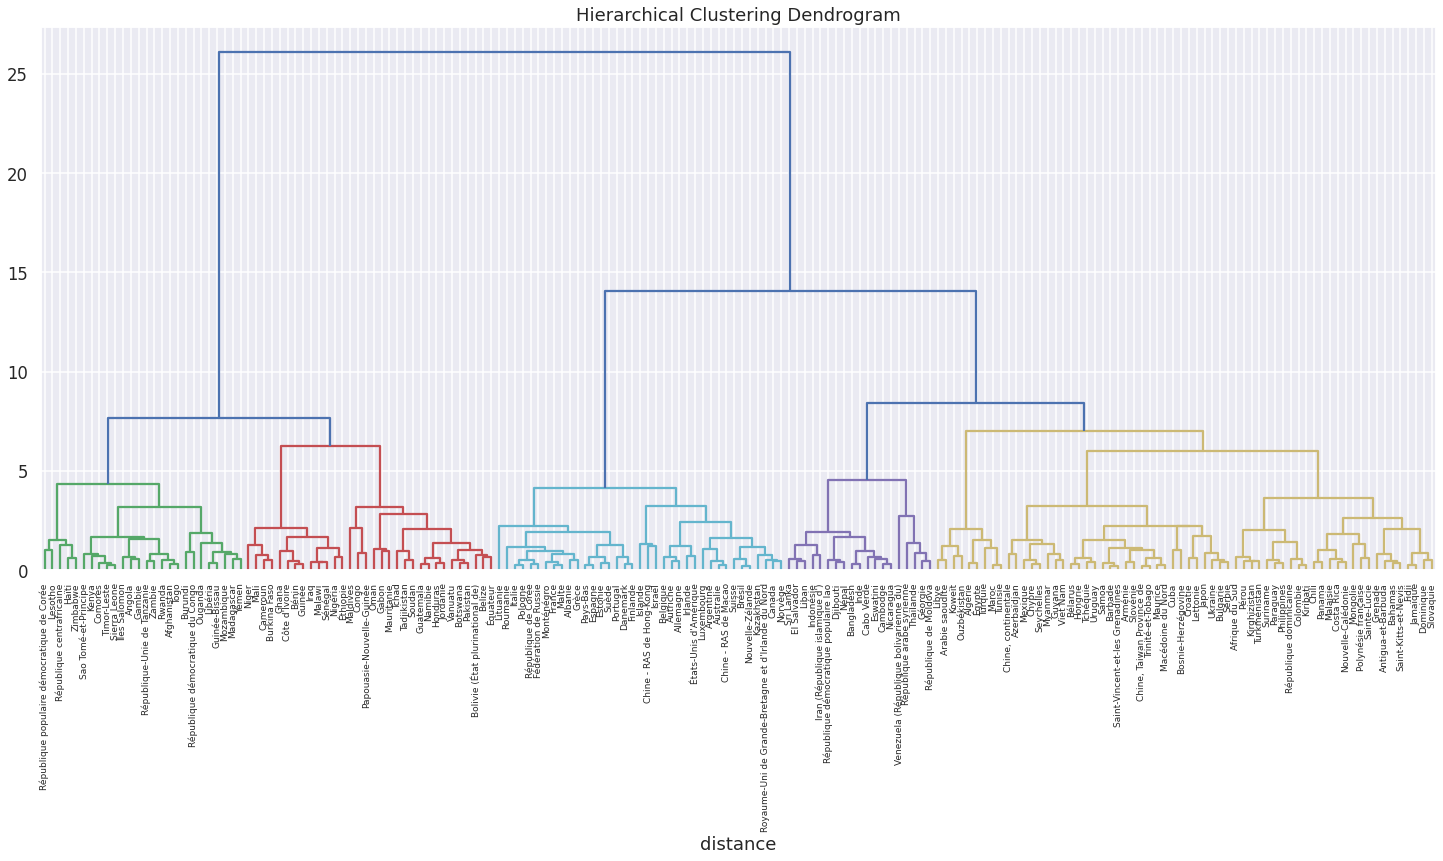

In [96]:
def plot_dendrogram(Z, names):
  plt.figure(figsize=(25,10))
  plt.title('Hierarchical Clustering Dendrogram')
  plt.xlabel('distance')
  plt.axhline(c='grey', lw=1, linestyle='dashed') # (can add this inside y=7.5) control number of clusters in the plot + add horizontal line.
  dendrogram(
      Z,
      labels = names,
      leaf_font_size=9,
      color_threshold=7.5,
      orientation = "top",
      )
  # livrable 1
  plt.savefig("P5_01_dendogramme.jpg", bbox_inches = "tight")
  # plt.tight_layout()
  plt.show()
  
# préparation des données pour le clustering
X = df.values
names = df.index

# centrage et réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# clustering hiérarchique
Z = linkage(X_scaled, 'ward')

# affichage du dendrogramme
plot_dendrogram(Z, names)

## 3. Clustering

Création d'une variable par groupe de cluster

In [97]:
# coupage du dendrogramme en 5 clusters
clusters = fcluster(Z, 5, criterion='maxclust')

# comparaison des clusters trouvés avec les classification des cours en différents thèmes
data_clusters = pd.DataFrame({"pays": names, "cluster": clusters})
# data_clusters.sort_values(["cluster", "pays"])
data_clusters = data_clusters.set_index('pays')
data_clusters.head(2)

,cluster
pays,
Arménie,5
Afghanistan,1


In [98]:
# ajout de la colonne "cluster" pour distinguer les groupes de pays
clustered = pd.merge(df, data_clusters, on="pays")
# clustered.reset_index(inplace=True)
clustered.head()

,croissance_pop_(en %),prot_animal_(en %),dispo_prot_hab_(en g),dispo_kcal_hab_(en kcal),cluster
pays,,,,,
Arménie,0.24,49.04,35525.45,1119820.0,5
Afghanistan,2.41,18.54,21027.65,827455.0,1
Albanie,-0.05,53.95,41175.65,1202675.0,3
Algérie,2.03,26.91,32959.50,1233335.0,5
Angola,3.33,30.97,19647.95,892425.0,1


In [99]:
# livrable 3
c_file = clustered.reset_index()
c_file = c_file[["pays", "cluster"]]
c_file.to_csv("P5_03_listepays.csv")

In [100]:
x = pd.DataFrame(clustered.groupby("cluster").mean())
x = x.round(2)

# selection des 2 cluster à étudier
x.sort_values("dispo_prot_hab_(en g)", ascending=False)

,croissance_pop_(en %),prot_animal_(en %),dispo_prot_hab_(en g),dispo_kcal_hab_(en kcal)
cluster,,,,
3,0.50,60.42,40264.43,1255442.16
5,0.75,49.34,31735.61,1099710.78
2,2.53,32.51,25554.45,951760.31
4,0.70,31.60,25141.39,991551.32
1,2.39,22.99,18767.74,797384.62


Pays du groupe 3 et 5 identifiés comme potentiellement intéressants

In [101]:
# additional stuffs if needed

# # x["nb_pays"] = clustered.groupby("cluster")["pays"].count()
# set(clustered[clustered["cluster"]==2]["pays"].unique())

## 4. Ajout d'autre caractéristiques

### 4.1 Création d'une variable sur le PIB

On ajoute la variable PIB que l'on a trouvé dans les données du site de la FAO. Cette valeur nous servira d'indicateur de la santé économique de nos pays.

In [102]:
pib = pd.read_csv("/content/drive/MyDrive/OC/P5/P5_rawfiles/P5_pib.csv")
pib = pib.rename(columns={'Zone' : 'pays', 'Valeur' : 'PIB_hab'})
pib = pib[["pays", "PIB_hab"]]
# pib["PIB_hab"] *= 1000000
pib.head()

,pays,PIB_hab
0,Afghanistan,1.798697e+04
1,Afrique du Sud,3.680939e+05
2,Albanie,1.514703e+04
3,Algérie,1.754150e+05
4,Allemagne,3.963768e+06


In [103]:
df = pd.merge(clustered, pib, on="pays")
df.head()

,pays,croissance_pop_(en %),prot_animal_(en %),dispo_prot_hab_(en g),dispo_kcal_hab_(en kcal),cluster,PIB_hab
0,Arménie,0.24,49.04,35525.45,1119820.0,5,12457.940705
1,Afghanistan,2.41,18.54,21027.65,827455.0,1,17986.967500
2,Albanie,-0.05,53.95,41175.65,1202675.0,3,15147.025232
3,Algérie,2.03,26.91,32959.50,1233335.0,5,175415.000298
4,Angola,3.33,30.97,19647.95,892425.0,1,101353.211652


### 4.2 Création d'une variable sur la population

In [104]:
pop = population.rename(columns={"Zone" : "pays"})
pop = pop[["pays", "nb_habitants"]]

df = pd.merge(df, pop, on="pays")
df = df[["pays", "cluster", "nb_habitants", "croissance_pop_(en %)", "prot_animal_(en %)", "dispo_prot_hab_(en g)", "dispo_kcal_hab_(en kcal)", "PIB_hab"]]
df.head()

,pays,cluster,nb_habitants,croissance_pop_(en %),prot_animal_(en %),dispo_prot_hab_(en g),dispo_kcal_hab_(en kcal),PIB_hab
0,Arménie,5,2951745.0,0.24,49.04,35525.45,1119820.0,12457.940705
1,Afghanistan,1,37171921.0,2.41,18.54,21027.65,827455.0,17986.967500
2,Albanie,3,2882740.0,-0.05,53.95,41175.65,1202675.0,15147.025232
3,Algérie,5,42228408.0,2.03,26.91,32959.50,1233335.0,175415.000298
4,Angola,1,30809787.0,3.33,30.97,19647.95,892425.0,101353.211652


On obtient donc un nouveau DataFrame avec des informations complémentaires pour notre étude. Deux nouvelles variables ont donc été ajouté pour réaliser une nouvelle analyse :
- Une variable sur la situation économique du pays : le PIB par habitant ; 
- Une variable sur la proportion de protéines de volailles parmi la disponibilité alimentaire de protéines par pays.

## 5. Vérification de la normalité

In [105]:
df = df.round(2)
main_df = df.copy()
df.head()

,pays,cluster,nb_habitants,croissance_pop_(en %),prot_animal_(en %),dispo_prot_hab_(en g),dispo_kcal_hab_(en kcal),PIB_hab
0,Arménie,5,2951745.0,0.24,49.04,35525.45,1119820.0,12457.94
1,Afghanistan,1,37171921.0,2.41,18.54,21027.65,827455.0,17986.97
2,Albanie,3,2882740.0,-0.05,53.95,41175.65,1202675.0,15147.03
3,Algérie,5,42228408.0,2.03,26.91,32959.50,1233335.0,175415.00
4,Angola,1,30809787.0,3.33,30.97,19647.95,892425.0,101353.21


On va chercher si notre variable suit une distribution normale. Pour cela, on effectue un test de Kolmogorov-Smirnov. On possède donc deux hypothèses qui sont les suivantes :

  \begin{cases}
    H_0      & \quad \text{F} = \text{F}_0\\
    H_1      & \quad \text{F} \neq\ \text{F}_0
  \end{cases}

> *avec **n = 177** car plus on a de "samples/effectifs" plus, on voit mieux la distribution*

H0 est donc l'hypothèse d'égalité que l'on cherche à ne pas rejeter. Si H0 est vraie, alors notre variable dans notre échantillon de pays suit la loi normale. On regarde d'abord la forme de la distribution.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


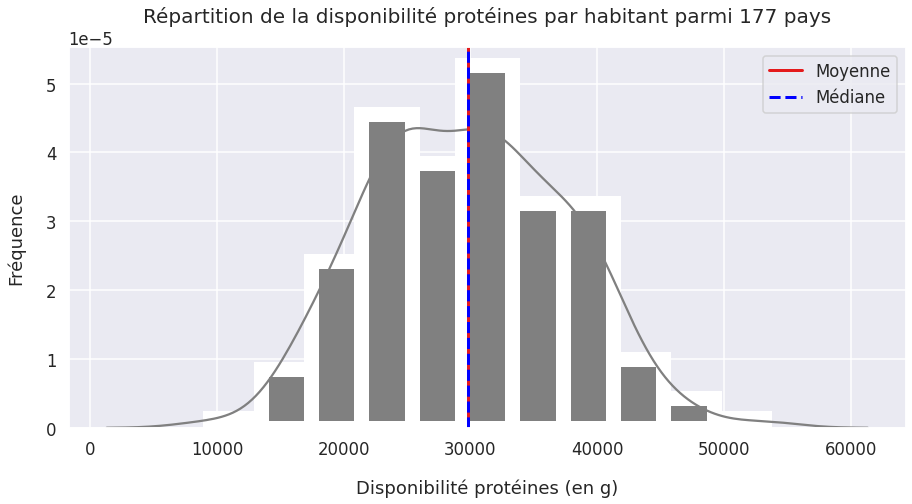

In [106]:
norm_hist = df["dispo_prot_hab_(en g)"]
# print("Disponibilité protéines par habitant:\n")

xbar = numpy.mean(norm_hist)
# print(f"Mean (esperance) = {round(xbar,2)}")

med = numpy.median(norm_hist)
# print(f"Median = {round(med,2)}")

sigma = numpy.std(norm_hist, ddof=1)
# print(f"Std (écart-type) = {round(sigma,2)}")

n_essence = len(df)
sigmasq = numpy.var(norm_hist, ddof=1)
# print(f"Variance = {round(sigmasq,2)}")

show_norm = plt.figure(figsize=(15,7))
show_norm = sns.distplot(norm_hist,
                  kde=True,
                  color="gray",
                  hist_kws={"linewidth": 15, "alpha":1})
show_norm = plt.axvline(x=norm_hist.mean(), label="Moyenne", linestyle="-", linewidth=3)
show_norm = plt.axvline(x=norm_hist.median(), label="Médiane", linestyle="--", linewidth=3, color="blue")
show_norm = plt.xlabel("Disponibilité protéines (en g)", labelpad=20)
show_norm = plt.ylabel("Fréquence", labelpad=20)
show_norm = plt.title("Répartition de la disponibilité protéines par habitant parmi 177 pays", fontsize=20, pad=25)
show_norm = plt.legend()


show_norm = plt.show()

On constate que l’écart entre l’histogrammme, primo-estimation de la densité de probabilité, et la densité gaussienne sont plutôt proches. Il semblerait, selon la représentation graphique, que la proportion de la disponibilité de protèines suive une loi normale.

Une fois la distribution représentée, on effectue un test statistique pour vérifier que l'adéquation de nos données est significative ou non.

In [107]:
print(st.stats.ttest_1samp(norm_hist,xbar))

alpha = 0.05
p = 0.99

print("\nP-value is " + str(p)) 
if p <= alpha: 
    print(f"Therefore: P({p}) < alpha({alpha})\nDoesn't follow a normal distribution (reject H0)") 
else: 
    print(f'Therefore: P({p}) > alpha({alpha})\nNormal distribution (H0 holds true)')

Ttest_1sampResult(statistic=-1.8898849747747822e-14, pvalue=0.9999999999999849)

P-value is 0.99
Therefore: P(0.99) > alpha(0.05)
Normal distribution (H0 holds true)


On ne peut pas rejeter l'hypothèse nulle (H0) au niveau de test  𝛼=  5% (0.05<0.99). La distribution de la proportion de protéine animale suit une loi normale.

In [108]:
# computing critical value
print(f"critical value: {round(1.36/(math.sqrt(len(norm_hist))),3)}")

critical value: 0.102


On obtient une valeur D = -1.89. Selon la table de Kolmogorov-Smirnov pour un échantillon N = 177 et un coefficient  𝛼= 0.05, on obtient 1.36 ÷ ‾√177 = 0.10. On ne peut pas rejeter l'hypothèse nulle (H0) à un coefficient  𝛼=5%. La distribution de la disponibilité protéines (en g) par habitant suit une loi normale.

*Source*: [Kolmogorov-Smirnov table](http://oak.ucc.nau.edu/rh83/Statistics/ks1/)

## 6.  Analyse par composantes principales

### 6.1 Normalisation

- You start by **`Standardizing`** the data since PCA's output is influenced based on the scale of the features of the data.

It is a common practice to normalize your data before feeding it to any machine learning algorithm.

To apply normalization, you will import **`StandardScaler`** module from the sklearn library and select only the features from the **`df`** you created in the Data Exploration step. Once you have the features, you will then apply scaling by doing `**fit_transform**` on the feature data.

While applying StandardScaler, each feature of your data should be normally distributed such that it will scale the distribution to a mean of zero and a standard deviation of one.

In [109]:
df.head(2)

,pays,cluster,nb_habitants,croissance_pop_(en %),prot_animal_(en %),dispo_prot_hab_(en g),dispo_kcal_hab_(en kcal),PIB_hab
0,Arménie,5,2951745.0,0.24,49.04,35525.45,1119820.0,12457.94
1,Afghanistan,1,37171921.0,2.41,18.54,21027.65,827455.0,17986.97


In [110]:
df.shape

(177, 8)

In [111]:
# préparation des données pour l'ACP
features = ['croissance_pop_(en %)',
       'prot_animal_(en %)', 'dispo_prot_hab_(en g)',
       'dispo_kcal_hab_(en kcal)', 'PIB_hab']

x = df.loc[:, features].values

# centrage et réduction
x = StandardScaler().fit_transform(x) # normalizing the features

# nombre de lignes et colonnes
x.shape

(177, 5)

Let's check whether the normalized data has a mean of zero and a standard deviation of one.

In [112]:
np.mean(x),np.std(x)

(-2.308260299785636e-17, 1.0)

Let's convert the normalized features into a tabular format with the help of DataFrame.

In [113]:
feat_cols = ['feature'+str(i) for i in range(x.shape[1])]
# feat_cols = features

normalised_data = pd.DataFrame(x,columns=feat_cols)
normalised_data.tail()

,feature0,feature1,feature2,feature3,feature4
172,-0.628653,0.949818,0.774843,1.982621,0.034697
173,0.734839,1.157594,1.257933,1.342006,-0.207937
174,-1.386149,0.425400,0.110713,-0.109906,-0.218344
175,-1.083151,1.118402,1.508530,1.386339,-0.241505
176,1.037837,-0.978644,-0.309014,-0.619738,-0.219512


In [114]:
normalised_data.shape

(177, 5)

### 6.2 Visualisation

In [115]:
# Calcul des composantes principales
pca_df = PCA(n_components=2).fit(x)
principalComponents_pca = pca_df.transform(x)

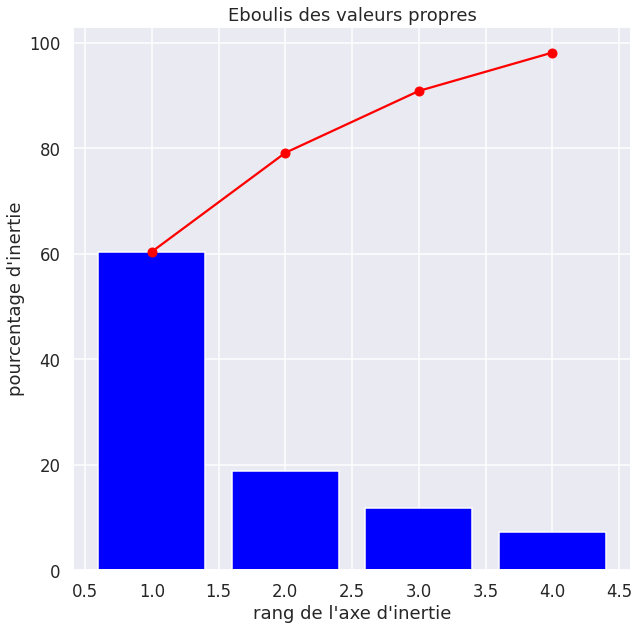

In [116]:
# Eboulis des valeurs propres
display_scree_plot(PCA(n_components=4).fit(x))

As the number of PCs is equal to the number of original variables, We should keep only the PCs which explain the most variance (70-95%) to make the interpretation easier. More the PCs you include that explains most variation in the original data, better will be the PCA model. This is highly subjective and based on the user interpretation (Cangelosi et al., 2007).

Next, let's create a DataFrame that will have the principal component values for all 177 samples.

In [117]:
principal_pca_df = pd.DataFrame(data = principalComponents_pca, columns = ['principal component 1', 'principal component 2'])
principal_pca_df.tail()

,principal component 1,principal component 2
172,2.167330,-0.254375
173,1.569896,-0.279500
174,0.751746,-0.587401
175,2.468615,-0.691614
176,-1.440360,0.188886


Once you have the principal components, you can find the explained_variance_ratio. It will provide you with the amount of information or variance each principal component holds after projecting the data to a lower dimensional subspace.

In [118]:
print('Explained variation per principal component: {}'.format(pca_df.explained_variance_ratio_))
print(f"rounded: {pca_df.explained_variance_ratio_*100}")

Explained variation per principal component: [0.60405414 0.1875718 ]
rounded: [60.40541419 18.75717996]


In [119]:
# quickier explained variance ratio test
df_transform = StandardScaler().fit_transform(x)
pca = PCA(n_components=2).fit(df_transform)
new_df = pca.transform(df_transform)
var_exp = pca.explained_variance_ratio_
var_exp

array([0.60405414, 0.1875718 ])

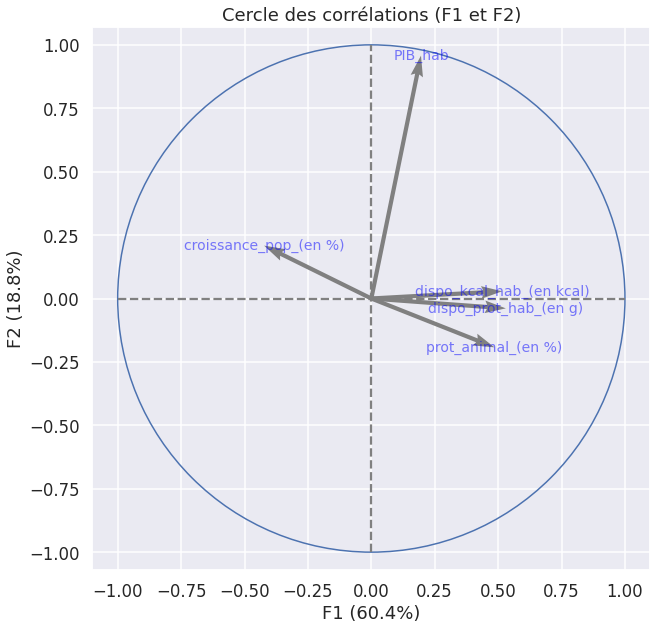

In [120]:
pcs = pca_df.components_
display_circles(pcs, 2, pca_df, [(0,1)], labels = np.array(features))

From the above output, you can observe that the principal component 1 holds 60.4% of the information while the principal component 2 holds only 18.8% of the information. Also, the other point to note is that while projecting 5-dimensional data to a 2-dimensional data, 20.8% information was lost.

Let's plot the visualization of the 177 samples along the principal component - 1 and principal component - 2 axis. It should give you good insight into how your samples are distributed among the two classes.

In [121]:
df['cluster'].replace(1, 'Group 1',inplace=True)
df['cluster'].replace(2, 'Group 2',inplace=True)
df['cluster'].replace(3, 'Group 3',inplace=True)
df['cluster'].replace(4, 'Group 4',inplace=True)
df['cluster'].replace(5, 'Group 5',inplace=True)

<Figure size 432x288 with 0 Axes>

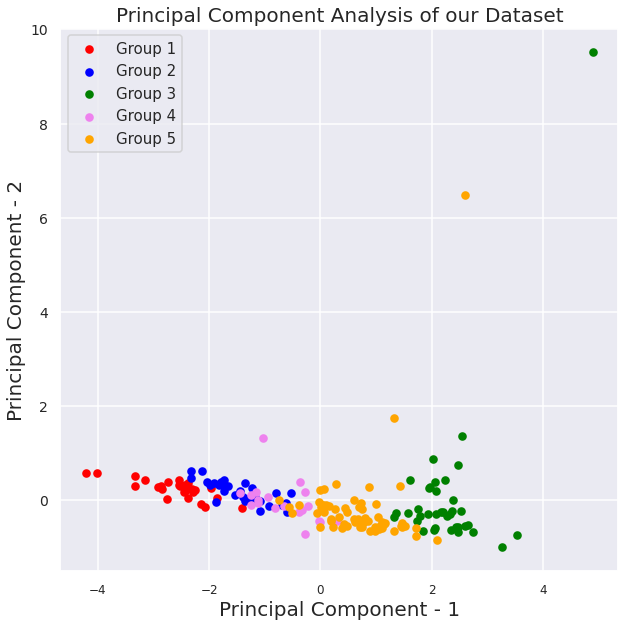

In [122]:
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis of our Dataset",fontsize=20)
targets = ['Group 1', 'Group 2', 'Group 3', 'Group 4', 'Group 5']
colors = ['red', 'blue', 'green', 'violet', 'orange']
for target, color in zip(targets,colors):
    indicesToKeep = df['cluster'] == target
    plt.scatter(principal_pca_df.loc[indicesToKeep, 'principal component 1']
               , principal_pca_df.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)

plt.legend(targets,prop={'size': 15})

In [123]:
# Calcul des composantes principales
pca_df = PCA(n_components=2).fit(x)
principalComponents_pca = pca_df.transform(x)

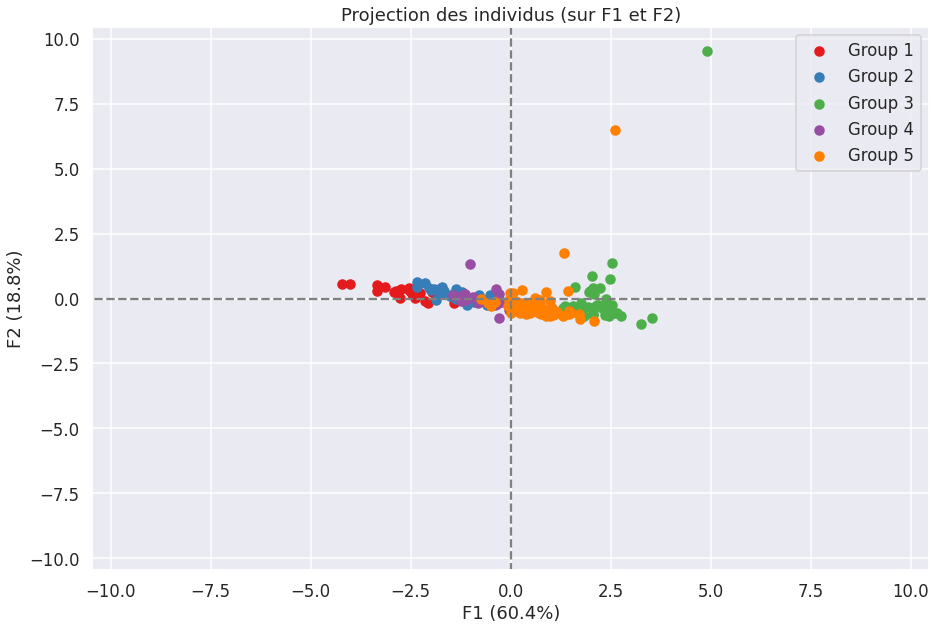

In [124]:
n_comp = 2
X_scaled = x
dots = df['cluster']

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

# Projection des individus
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1)], illustrative_var = dots) # , labels=df.pays

### **[**BONUS**]** Autre méthodes pour l'ACP

**Standardize the Data**

PCA is effected by scale so you need to scale the features in your data before applying PCA. Use StandardScaler to help you standardize the dataset’s features onto unit scale (mean = 0 and variance = 1) which is a requirement for the optimal performance of many machine learning algorithms. If you want to see the negative effect not scaling your data can have, scikit-learn has a section on the effects of not standardizing your data.

In [125]:
feat = ['croissance_pop_(en %)',
       'prot_animal_(en %)', 'dispo_prot_hab_(en g)',
       'dispo_kcal_hab_(en kcal)', 'PIB_hab']
       
# Separating out the features
x = df.loc[:, feat].values
# Separating out the target
y = df.loc[:,['cluster']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

**PCA Projection to 2D**

The original data has 4 columns (sepal length, sepal width, petal length, and petal width). In this section, the code projects the original data which is 4 dimensional into 2 dimensions. I should note that after dimensionality reduction, there usually isn’t a particular meaning assigned to each principal component. The new components are just the two main dimensions of variation.

In [126]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

Concatenating DataFrame along axis = 1. finalDf is the final DataFrame before plotting the data.

In [127]:
finalDf = pd.concat([principalDf, df[['cluster']]], axis = 1)
finalDf.head()

,principal component 1,principal component 2,cluster
0,1.140446,-0.507859,Group 5
1,-2.516955,0.286319,Group 1
2,2.048884,-0.633588,Group 3
3,-0.007732,0.202402,Group 5
4,-2.371768,0.367636,Group 1


**Visualize 2D Projection**

This section is just plotting 2 dimensional data. Notice on the graph below that the classes seem well separated from each other.

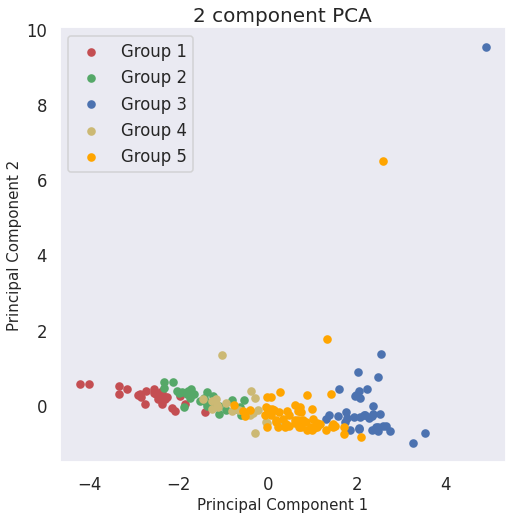

In [128]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Group 1', 'Group 2', 'Group 3', 'Group 4', 'Group 5']
colors = ['r', 'g', 'b', 'y', 'orange']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['cluster'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

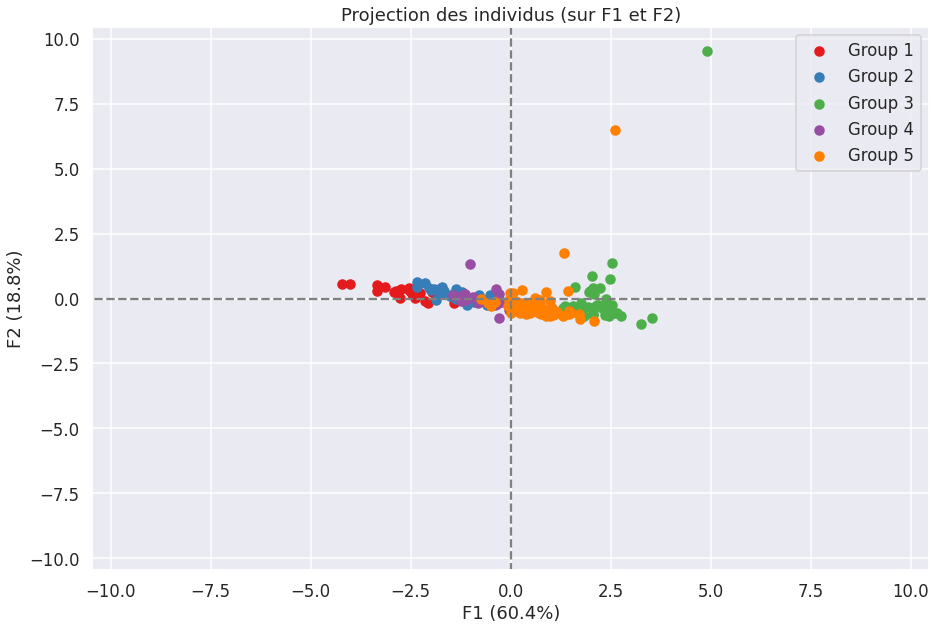

In [129]:
n_comp = 2
X_scaled = x
dots = df['cluster']

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

# Projection des individus
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1)], illustrative_var = dots) # , labels=df.pays

In [130]:
pca

PCA(n_components=2)

**Explained Variance**

The explained variance tells you how much information (variance) can be attributed to each of the principal components. This is important as while you can convert 4 dimensional space to 2 dimensional space, you lose some of the variance (information) when you do this. By using the attribute explained_variance_ratio_, you can see that the first principal component contains 60.4% of the variance and the second principal component contains 18.8% of the variance. Together, the two components contain 79.2% of the information.

In [131]:
pca.explained_variance_ratio_

array([0.60405414, 0.1875718 ])

### 6.3 Centroids

In [132]:
# centroids coordinates
coor_centroids = pd.DataFrame(X_scaled, columns=features, index=df.cluster)
coor_centroids

,croissance_pop_(en %),prot_animal_(en %),dispo_prot_hab_(en g),dispo_kcal_hab_(en kcal),PIB_hab
cluster,,,,,
Group 5,-0.904917,0.386209,0.748640,0.426526,-0.237938
Group 1,1.028925,-1.511149,-1.143703,-1.349019,-0.235101
Group 3,-1.163356,0.691652,1.486139,0.929707,-0.236558
Group 5,0.690280,-0.990464,0.413716,1.115907,-0.154313
Group 1,1.848803,-0.737898,-1.323790,-0.954454,-0.192320
...,...,...,...,...,...
Group 3,-0.628653,0.949818,0.774843,1.982621,0.034697
Group 3,0.734839,1.157594,1.257933,1.342006,-0.207937
Group 5,-1.386149,0.425400,0.110713,-0.109906,-0.218344


In [133]:
# livrable 4
cc = coor_centroids.groupby("cluster").mean()
cc = cc.drop(columns="PIB_hab")
cc = cc.reset_index()
cc.to_csv("P5_04_centroidscoordinates.csv")
cc

,cluster,croissance_pop_(en %),prot_animal_(en %),dispo_prot_hab_(en g),dispo_kcal_hab_(en kcal)
0,Group 1,1.006646,-1.234058,-1.438680,-1.531638
1,Group 2,1.132802,-0.642097,-0.552837,-0.594108
2,Group 3,-0.672730,1.094242,1.367201,1.250165
3,Group 4,-0.493102,-0.698935,-0.606752,-0.352456
4,Group 5,-0.447024,0.403578,0.254576,0.305946


In [134]:
centroids = finalDf.groupby("cluster").mean()
centroids["group"] = centroids.index
centroids

,principal component 1,principal component 2,group
cluster,,,
Group 1,-2.623488,0.235451,Group 1
Group 2,-1.432403,0.158046,Group 2
Group 3,2.273539,0.062262,Group 3
Group 4,-0.652776,-0.044756,Group 4
Group 5,0.671895,-0.200517,Group 5


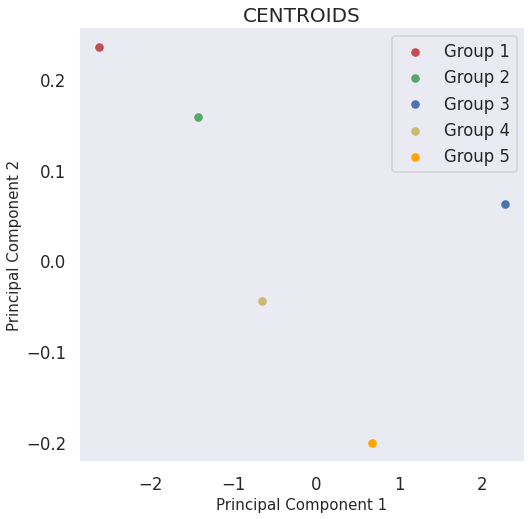

In [135]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('CENTROIDS', fontsize = 20)
targets = ['Group 1', 'Group 2', 'Group 3', 'Group 4', 'Group 5']
colors = ['r', 'g', 'b', 'y', 'orange']
for target, color in zip(targets,colors):
    indicesToKeep = centroids['group'] == target
    ax.scatter(centroids.loc[indicesToKeep, 'principal component 1']
               , centroids.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

### 6.4 Deux groupes selectionnés

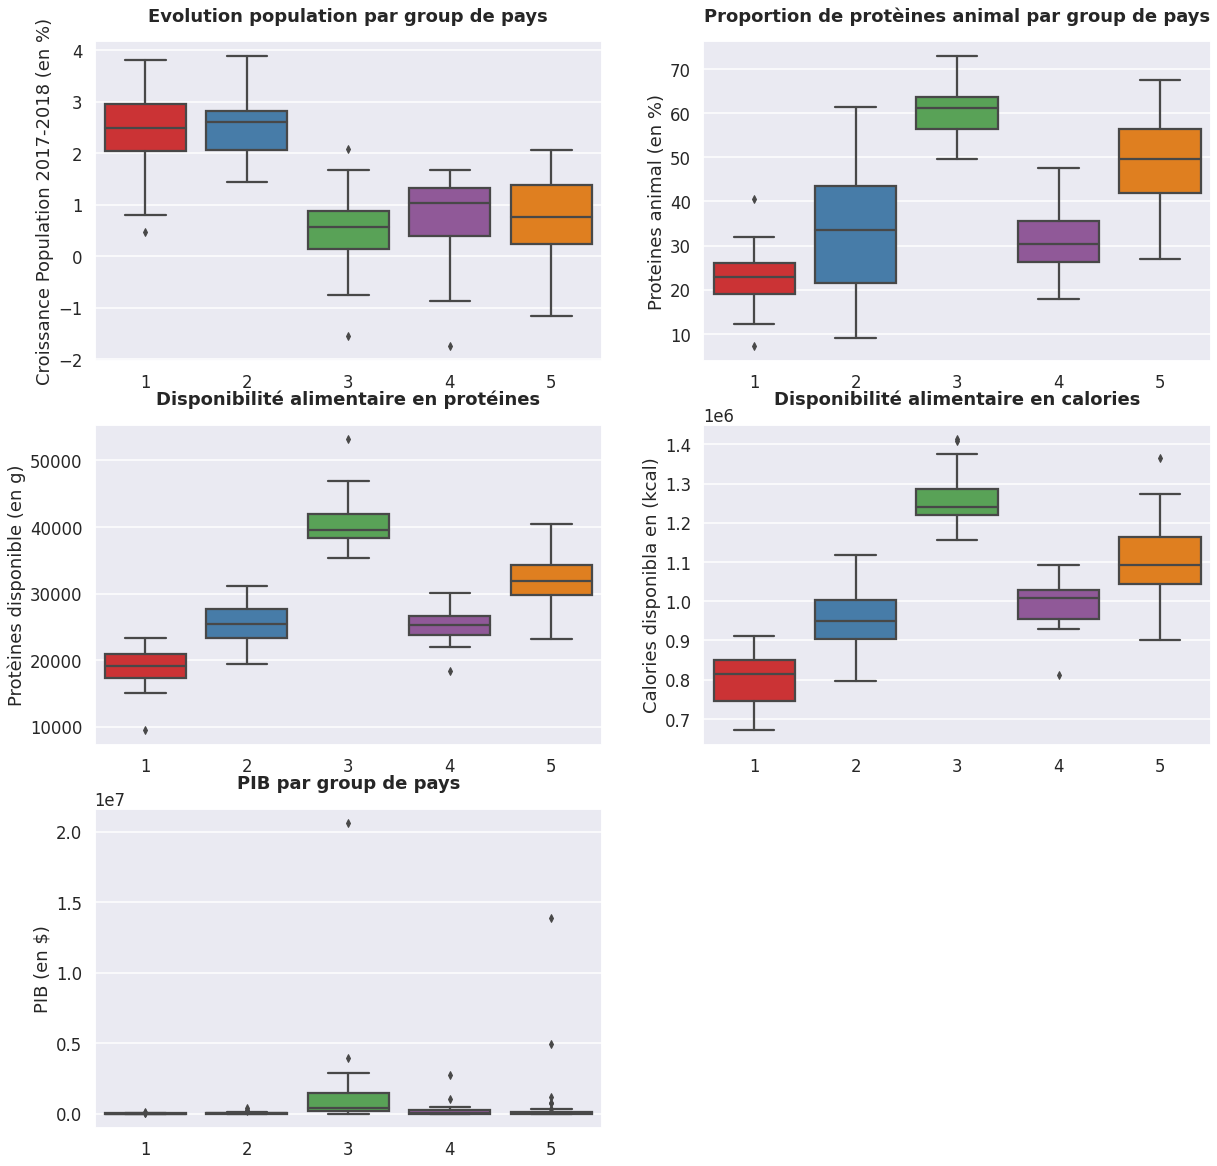

In [136]:
plt.figure(figsize=(20,20))

plt.subplot(3,2,1)
var1 = sns.boxplot(x='cluster', y="croissance_pop_(en %)", data=main_df)
var1 = plt.xlabel('', labelpad=20)
var1 = plt.ylabel('Croissance Population 2017-2018 (en %)')
var1 = plt.title('Evolution population par group de pays', pad=20, fontweight='bold')
var1 = plt.savefig('var1.jpg')

plt.subplot(3,2,2)
var2 = sns.boxplot(x='cluster', y="prot_animal_(en %)", data=main_df)
var2 = plt.xlabel('', labelpad=20)
var2 = plt.ylabel('Proteines animal (en %)')
var2 = plt.title('Proportion de protèines animal par group de pays', pad=20, fontweight='bold')
var2 = plt.savefig('var2.jpg')

plt.subplot(3,2,3)
var3 = sns.boxplot(x='cluster', y="dispo_prot_hab_(en g)", data=main_df)
var3 = plt.xlabel('', labelpad=20)
var3 = plt.ylabel('Protèines disponible (en g)')
var3 = plt.title('Disponibilité alimentaire en protéines', pad=20, fontweight='bold')
var3 = plt.savefig('var3.jpg')

plt.subplot(3,2,4)
var4 = sns.boxplot(x='cluster', y="dispo_kcal_hab_(en kcal)", data=main_df)
var4 = plt.xlabel('', labelpad=20)
var4 = plt.ylabel('Calories disponibla en (kcal)')
var4 = plt.title('Disponibilité alimentaire en calories', pad=20, fontweight='bold')
var4 = plt.savefig('var4.jpg')

plt.subplot(3,2,5)
var5 = sns.boxplot(x='cluster', y="PIB_hab", data=main_df)
var5 = plt.xlabel('', labelpad=20)
var5 = plt.ylabel('PIB (en $)')
var5 = plt.title('PIB par group de pays', pad=20, fontweight='bold')
var5 = plt.savefig('var5.jpg')

## 7. Test de comparaison

In [137]:
members = df['cluster'].value_counts().rename_axis('Cluster').reset_index(name='Nb de pays')
members = members.sort_values(by="Cluster").reset_index()
members.drop(columns="index")

,Cluster,Nb de pays
0,Group 1,26
1,Group 2,32
2,Group 3,37
3,Group 4,19
4,Group 5,63


On observe que les pays sont répartis de manière plutôt homogènes dans nos clusters. Sauf, le cluster 4 qui compte moins de pays que les autres, et le cluster 5 qui compte plus de pays.

In [138]:
selected = df.groupby("cluster").mean()
selected[features]

,croissance_pop_(en %),prot_animal_(en %),dispo_prot_hab_(en g),dispo_kcal_hab_(en kcal),PIB_hab
cluster,,,,,
Group 1,2.385000,22.994231,18767.738462,7.973846e+05,1.966032e+04
Group 2,2.526562,32.510000,25554.448437,9.517603e+05,5.632828e+04
Group 3,0.500541,60.421622,40264.432432,1.255442e+06,1.352590e+06
Group 4,0.702105,31.596316,25141.392105,9.915513e+05,2.928798e+05
Group 5,0.753810,49.319206,31740.284127,1.099965e+06,4.182400e+05


Dans cette partie, on va réaliser des statistiques inférentielles pour définir la significativité de nos données. On va s'intéresser aux clusters 3 et 5. En effet, ces deux clusters se caractérisent par de forte disponibilités alimentaires, une croissance de la population stable et un PIB important. Ces groupes de pays sont donc envisageables pour se développer à l'international.

### 7.1 Par moyenne

On effectue ensuite la comparaison de moyennes entre nos clusters 3 et 5 sur la disponibilité alimentaire en protéines.

In [139]:
np.random.seed(8)
rcParams["figure.figsize"] = 20,10
rcParams["font.size"] = 30
sns.set()

def plot_dist(inp):
  ax = sns.distplot(inp)
  plt.axvline(np.mean(inp), color="k", linestyle="dashed", linewidth=5)
  _, max_ = plt.ylim()
  plt.text(
      inp.mean() + inp.mean() /10,
      max_-max_/10,
      "Mean: {:.2f}".format(inp.mean()))
  return plt.figure

# to visulaize the samples one by one
# plot_dist(group3)
# plot_dist(group5)

In [140]:
group3 = main_df[main_df["cluster"]==3]["dispo_prot_hab_(en g)"]
group5 = main_df[main_df["cluster"]==5]["dispo_prot_hab_(en g)"]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


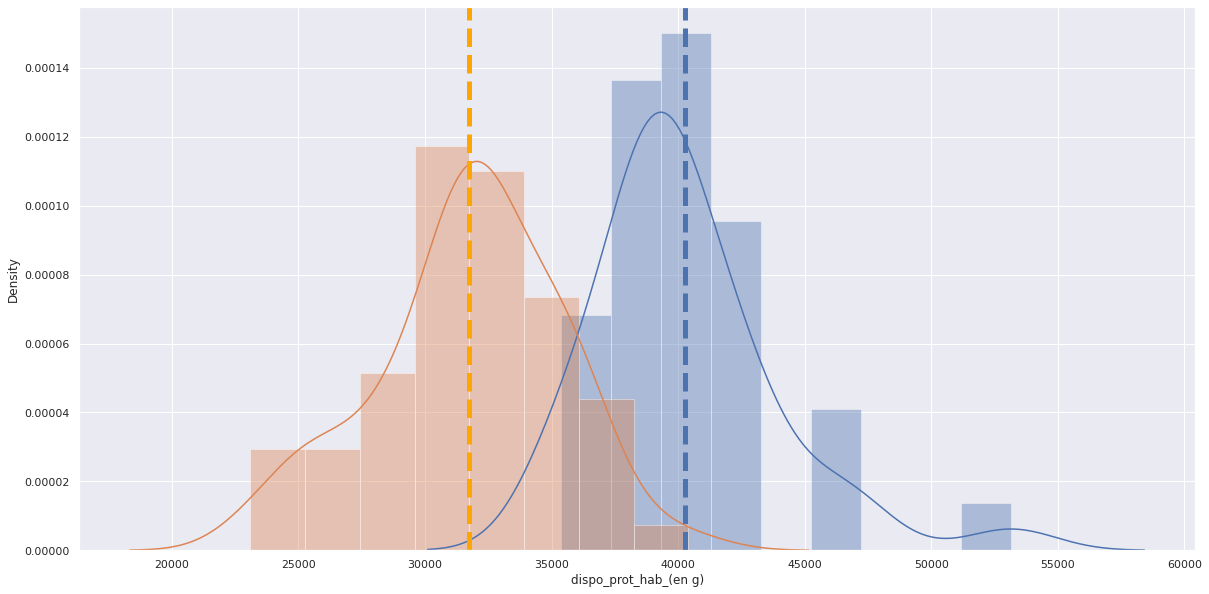

In [141]:
plt.figure()
ax1 = sns.distplot(group3)
ax2 = sns.distplot(group5)
plt.axvline(np.mean(group3), color="b", linestyle="dashed", linewidth=5)
plt.axvline(np.mean(group5), color="orange", linestyle="dashed", linewidth=5)

The Independent Samples t test is commonly used to test the following:
- Statistical differences between the means of two groups.
- Statistical differences between the means of two interventions.
- Statistical differences between the means of two change scores.

Use an independent samples t test when you want to compare the means of precisely two groups—no more and no less! Typically, you perform this test to determine whether two population means are different.

We will perform a t-test to find out if they're really different or the same from each other.

- If p-value > alpha, then we fail to reject the null hypothesis.
- But if p-value < alpha, that means there is a significant relationship (*a.k.a.* both distributions are different from each other)
---

On effectuera un t-test de Student pour vérifier les hypothèses suivantes :
- H0 = moyennes égaux
- Ha = moyennes différentes

  \begin{cases}
    H_0      & \quad \mu^2_1 = \mu^2_2\\
    H_1      & \quad \mu^2_1 \neq\ \mu^2_2
  \end{cases}

In [142]:
st.stats.ttest_ind(group3,group5, equal_var=True)

Ttest_indResult(statistic=11.348396282236177, pvalue=1.4781553222786553e-19)

La valeur de p-value est extrêmement petit, on est confiant de rejeter l'hypothèse null. Le t test de Student montre donc qu'il y a une différence significatif entre la disponibilité alimentaire en protèines entre le groupe 3 et le groupe 5. Faisons encore un autre test pour bien vérifier.

In [143]:
def compare_groups(arr_1, arr_2, alpha, sample_size):
  stat, p = ttest_ind(arr_1, arr_2)
  print('Statistics=%.3f, p=%.3f' % (stat, p))
  if p > alpha:
    print('Same distribution of means (fail to reject H0)')
  else:
    print('Different distributions of means (reject H0)')

# ttest_ind = t-test of independence between 2 groups

In [144]:
alpha = 0.05

# define a sample size
sample_size = 20

sampled3 = np.random.choice(group3, sample_size)
sampled5 = np.random.choice(group5, sample_size)

compare_groups(sampled3, sampled5, alpha, sample_size)

Statistics=8.202, p=0.000
Different distributions of means (reject H0)


### 7.2 Par variance

Ensuite, on vérifie si la condition d'égalité des variances est vérifiée pour nos variables. On aura donc une hypothèse nulle (H0) où la variance dans le cluster 3 et la variance dans le cluster 5 sera identique et une hypothèse alternative (H1) où nos deux variances seront différentes.

- Le test de Bartlett est utilisé pour vérifier officiellement si plusieurs échantillons ont des variances égales ou pas.
- Les variances égales entre les échantillons sont appelées: ***homogénéité des variances***.
- Certains tests statistiques, par exemple l'analyse de variance (ANOVA), assument que les écarts sont égaux à travers des groupes ou des échantillons.
- Le test de Bartlett est utilisé pour vérifier cette hypothèse.

Nous allons rejeter l'hypothèse null **H0** seulement si **p-value** est inférieur à **alpha=0.05**.


  \begin{cases}
    H_0      & \quad \sigma^2_1 = \sigma^2_2\\
    H_1      & \quad \sigma^2_1 \neq\ \sigma^2_2
  \end{cases}

In [145]:
st.stats.bartlett(group3,group5)

BartlettResult(statistic=0.0037838504116673166, pvalue=0.950950653465837)

Avec une p-value = 0.95, on ne peut pas rejeter l'hypothèse nulle (H0). Nos variances sont donc égales.

- When the P-Value is bigger than the significance level, we cannot reject the null hypothesis. When it is smaller, we cannot accept the null hypothesis.

> *Here, the P-Value (0.95) is bigger than the significance level (0.05), so we cannot reject the null hypothesis that our 2 groups has equal variances*

### 7.3 Mann-Whitney U test


Le PIB par habitant ne suivait pas la loi normale. On va donc choisir de faire un test de Mann-Whitney pour juger de la significativité du PIB par habitant pour les clusters 3 et 5. La réalisation d'un test de Mann-Whitney ne demande pas de vérification particulière comme pour la réalisation d'un test paramétrique comme le test de Student.

> If your data is following non-normal distribution, then you must go for Mann whitney U test instead of independent t test. It depends on what kind of hypothesis you want to test. If you want to test the mean difference, then use the t-test; if you want to test stochastic equivalence, then use the U-test.
>
> It is a non-parametric test that is used to compare two sample means that come from the same population, and used to test whether two sample means are equal or not. Usually, the Mann-Whitney U test is used when the data is ordinal or when the assumptions of the t-test are not met.

In [146]:
PIB3 = main_df[main_df["cluster"]==3]["PIB_hab"]
PIB5 = main_df[main_df["cluster"]==5]["PIB_hab"]

In [147]:
st.stats.mannwhitneyu(group3, group5)

MannwhitneyuResult(statistic=62.0, pvalue=1.706766411064583e-15)

Le résultat du test de Mann-Whitney montre une différence significative entre le cluster 1 et le cluster 3. Le PIB par habitant dans ces deux clusters sont donc différents.

## **CONCLUSION**

On représente graphiquement les données en lien avec nos variables pour chacun de nos clusters.

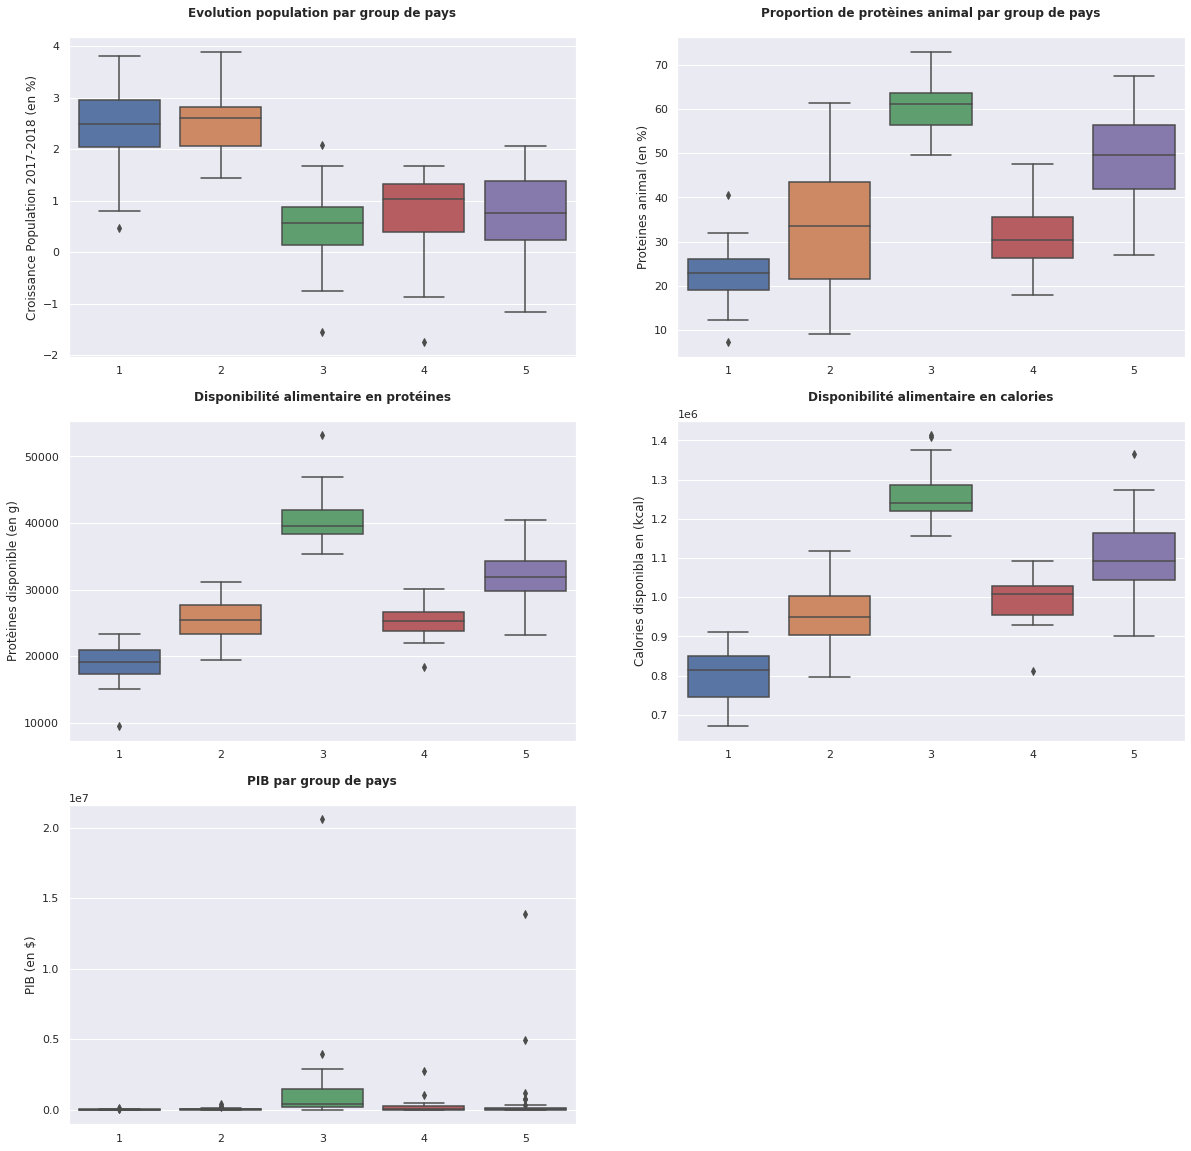

In [148]:
plt.figure(figsize=(20,20))
# grouped = main_df.loc[(main_df["cluster"]==3) | (main_df["cluster"]==5)]

plt.subplot(3,2,1)
var1 = sns.boxplot(x='cluster', y="croissance_pop_(en %)", data=main_df)
var1 = plt.xlabel('', labelpad=20)
var1 = plt.ylabel('Croissance Population 2017-2018 (en %)')
var1 = plt.title('Evolution population par group de pays', pad=20, fontweight='bold')
var1 = plt.savefig('var1.jpg')

plt.subplot(3,2,2)
var2 = sns.boxplot(x='cluster', y="prot_animal_(en %)", data=main_df)
var2 = plt.xlabel('', labelpad=20)
var2 = plt.ylabel('Proteines animal (en %)')
var2 = plt.title('Proportion de protèines animal par group de pays', pad=20, fontweight='bold')
var2 = plt.savefig('var2.jpg')

plt.subplot(3,2,3)
var3 = sns.boxplot(x='cluster', y="dispo_prot_hab_(en g)", data=main_df)
var3 = plt.xlabel('', labelpad=20)
var3 = plt.ylabel('Protèines disponible (en g)')
var3 = plt.title('Disponibilité alimentaire en protéines', pad=20, fontweight='bold')
var3 = plt.savefig('var3.jpg')

plt.subplot(3,2,4)
var4 = sns.boxplot(x='cluster', y="dispo_kcal_hab_(en kcal)", data=main_df)
var4 = plt.xlabel('', labelpad=20)
var4 = plt.ylabel('Calories disponibla en (kcal)')
var4 = plt.title('Disponibilité alimentaire en calories', pad=20, fontweight='bold')
var4 = plt.savefig('var4.jpg')

plt.subplot(3,2,5)
var5 = sns.boxplot(x='cluster', y="PIB_hab", data=main_df)
var5 = plt.xlabel('', labelpad=20)
var5 = plt.ylabel('PIB (en $)')
var5 = plt.title('PIB par group de pays', pad=20, fontweight='bold')
var5 = plt.savefig('var5.jpg')

Les pays du cluster 3 sont ceux ayant une croissance de population assez stable, disponibilités alimentaires et un PIB important. On va donc chercher les pays-cible dans ce cluster.

In [149]:
pays_cible = set(main_df[main_df["cluster"]==3]["pays"])

print(f"Nombre de pays dans le groupe 3: {len(pays_cible)} \n")
sorted(pays_cible)

Nombre de pays dans le groupe 3: 37 



['Albanie',
 'Allemagne',
 'Argentine',
 'Australie',
 'Autriche',
 'Belgique',
 'Brésil',
 'Canada',
 'Chine - RAS de Hong-Kong',
 'Chine - RAS de Macao',
 'Danemark',
 'Espagne',
 'Estonie',
 'Finlande',
 'France',
 'Fédération de Russie',
 'Grèce',
 'Irlande',
 'Islande',
 'Israël',
 'Italie',
 'Kazakhstan',
 'Lituanie',
 'Luxembourg',
 'Malte',
 'Monténégro',
 'Norvège',
 'Nouvelle-Zélande',
 'Pays-Bas',
 'Pologne',
 'Portugal',
 'Roumanie',
 "Royaume-Uni de Grande-Bretagne et d'Irlande du Nord",
 'République de Corée',
 'Suisse',
 'Suède',
 "États-Unis d'Amérique"]

Cette liste de pays peut constituer des pays-cibles intéressants pour développer un marché à l'international.

### [BONUS] Aller plus loin..

In [150]:
setting = pd.concat([principal_pca_df, df], axis=1)
setting = setting[['principal component 1', 'principal component 2', 'pays', 'cluster']]
setting.rename(columns={"principal component 1": "F1", "principal component 2": "F2"}, inplace=True)
print(f"Dataframe shape: {setting.shape}")
print('Détails des valeurs manquantes:\n' + str(setting.isna().sum()) + '\n')
setting.head()

Dataframe shape: (177, 4)
Détails des valeurs manquantes:
F1         0
F2         0
pays       0
cluster    0
dtype: int64



,F1,F2,pays,cluster
0,1.140446,-0.507859,Arménie,Group 5
1,-2.516955,0.286319,Afghanistan,Group 1
2,2.048884,-0.633588,Albanie,Group 3
3,-0.007732,0.202402,Algérie,Group 5
4,-2.371768,0.367636,Angola,Group 1


In [151]:
# plt.figure(figsize=(10,10))
# sns.scatterplot(data=setting, x="F1",y="F2")

# for i in range(setting.shape[0]):
#  plt.text(x=setting.F1[i]+0.3,y=setting.F2[i]+0.3,s=setting.pays[i])
# plt.xlim(setting.F1.min()-1,setting.F1.max()+1)                #set x limit
# plt.ylim(setting.F2.min()-1,setting.F2.max()+1)              #set y limit 
# plt.title("Projection des individus (sur F1 et F2)") #title
# plt.xlabel("principal component 1") #x label
# plt.ylabel("principal component 2") #y label
# plt.show()

In [152]:
cible = setting[(setting["F1"]>0.0) & (setting["F2"]>0.0)]
g3 = cible[cible["cluster"]=="Group 3"]
g5 = cible[cible["cluster"]=="Group 5"]

print(f"Dataframe shape: {cible.shape}\n")
print(f"Nb de pays dans Cluster 3: {len(g3)}")
print(f"Nb de pays dans Cluster 5: {len(g5)}\n")

print(f"Cibles envisageables (groupe 3):\n{'-'*20}")
print(g3[['pays', 'cluster']].sort_values(by="pays"))

print(f"Cibles envisageables (groupe 5):\n{'-'*20}")
print(g5[['pays', 'cluster']].sort_values(by="pays"))

Dataframe shape: (17, 4)

Nb de pays dans Cluster 3: 10
Nb de pays dans Cluster 5: 7

Cibles envisageables (groupe 3):
--------------------
                                                  pays  cluster
52                                           Allemagne  Group 3
7                                            Australie  Group 3
14                                              Brésil  Group 3
21                                              Canada  Group 3
46                                              France  Group 3
131                               Fédération de Russie  Group 3
73                                              Italie  Group 3
159  Royaume-Uni de Grande-Bretagne et d'Irlande du...  Group 3
83                                 République de Corée  Group 3
161                              États-Unis d'Amérique  Group 3
Cibles envisageables (groupe 5):
--------------------
                    pays  cluster
136      Arabie saoudite  Group 5
27   Chine, continentale  Group 5


In [153]:
final_target = cible[cible["cluster"]=="Group 3"]
print(f"Dataframe shape: {final_target.shape}\n\nPAYS CIBLE (final):")
final_target[['pays', 'cluster']]

Dataframe shape: (10, 4)

PAYS CIBLE (final):


,pays,cluster
7,Australie,Group 3
14,Brésil,Group 3
21,Canada,Group 3
46,France,Group 3
52,Allemagne,Group 3
73,Italie,Group 3
83,République de Corée,Group 3
131,Fédération de Russie,Group 3
159,Royaume-Uni de Grande-Bretagne et d'Irlande du...,Group 3
161,États-Unis d'Amérique,Group 3


### [en plus] alternative..

In [154]:
cible = setting[(setting["F1"]<0.0) & (setting["F2"]<0.0)]
g1 = cible[cible["cluster"]=="Group 1"]
g2 = cible[cible["cluster"]=="Group 2"]
g3 = cible[cible["cluster"]=="Group 3"]
g4 = cible[cible["cluster"]=="Group 4"]
g5 = cible[cible["cluster"]=="Group 5"]

print(f"Dataframe shape: {cible.shape}\n")
print(f"Nb de pays dans Cluster 1: {len(g1)}")
print(f"Nb de pays dans Cluster 2: {len(g2)}")
print(f"Nb de pays dans Cluster 3: {len(g3)}")
print(f"Nb de pays dans Cluster 4: {len(g4)}")
print(f"Nb de pays dans Cluster 5: {len(g5)}\n")

print(f"Cibles envisageables (Groupe 1):\n{'-'*20}")
print(g1[['pays', 'cluster']].sort_values(by="cluster"))

print(f"\nCibles envisageables (Groupe 2):\n{'-'*20}")
print(g2[['pays', 'cluster']].sort_values(by="cluster"))

print(f"\nCibles envisageables (Groupe 4):\n{'-'*20}")
print(g4[['pays', 'cluster']].sort_values(by="cluster"))

Dataframe shape: (31, 4)

Nb de pays dans Cluster 1: 3
Nb de pays dans Cluster 2: 11
Nb de pays dans Cluster 3: 0
Nb de pays dans Cluster 4: 10
Nb de pays dans Cluster 5: 7

Cibles envisageables (Groupe 1):
--------------------
                                          pays  cluster
23                   République centrafricaine  Group 1
82  République populaire démocratique de Corée  Group 1
88                                     Lesotho  Group 1

Cibles envisageables (Groupe 2):
--------------------
                                pays  cluster
12   Bolivie (État plurinational de)  Group 2
13                          Botswana  Group 2
15                            Belize  Group 2
30                             Congo  Group 2
40                          Équateur  Group 2
50                             Gabon  Group 2
62                          Honduras  Group 2
78                          Jordanie  Group 2
96                          Maldives  Group 2
106                          Nami

# **{**sources**}**

1. https://stattrek.com/anova/homogeneity/bartletts-test.aspx
2. https://blogs.sas.com/content/iml/2019/05/20/critical-values-kolmogorov-test.html
3. http://oak.ucc.nau.edu/rh83/Statistics/ks1/
4. https://www.real-statistics.com/non-parametric-tests/goodness-of-fit-tests/two-sample-kolmogorov-smirnov-test/
5. https://www.graphpad.com/guides/prism/latest/statistics/interpreting_results_kolmogorov-smirnov_test.htm
6. https://www.youtube.com/watch?v=cltWQsmBg0k&t=515s&ab_channel=Dr.ToddGrande
8. https://www.analyticsvidhya.com/blog/2019/08/comprehensive-guide-k-means-clustering/
7. https://www.youtube.com/watch?v=VDxJMa3aCE0&ab_channel=PythonforEconometrics
8. http://www.jybaudot.fr/Analdonnees/agregcah.html